#### Student    : Nasrin Sultana Nipa
#### Student ID : 50618423
#### Assignment : 06
#### Course     : CS-6443-001

# Clustering: $k$-means

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

This code will create 3 simulated groups, and the random state and standard deviation is chosen so that we end up with one group "far" from the other two, and two that are "touching" at their boundary. So, here we will generate a dataset with 200 samples, divided into 3 clusters, and then visualize it using scatter plot where each cluster is represented by a different color.

Where the colors correspond to classes as follows:
    
    purple:     class 0
    grey-green: class 1
    yellow:     class 2

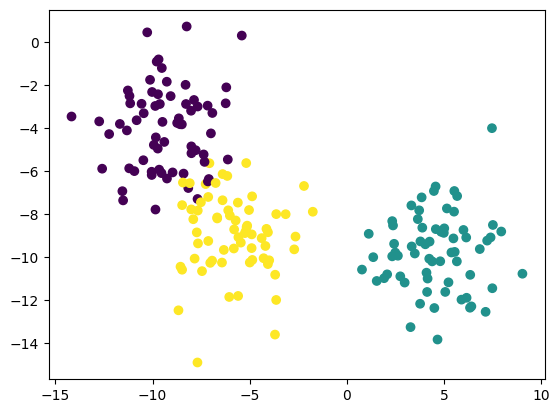

In [73]:
X, y = make_blobs(
    n_samples=200, centers=3, n_features=2, random_state=21, cluster_std=1.8
)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [74]:
# Let's take a look at the first 5 rows of the raw data:
print("X:\n{}".format(X[:5]))
print("y:\n{}".format(y[:5]))

X:
[[ -8.4796732  -10.59435522]
 [ -4.89258431  -8.94718551]
 [-11.18753493  -2.49554353]
 [  2.34057229  -8.32943212]
 [ -7.10270071  -6.36798487]]
y:
[2 2 0 1 0]


Here, X contains the features of the data, where each row represents a sample and each column represents a feature. y contains the class labels corresponding to each sample. For example, the first row of X corresponds to the first element of y, indicating that the sample [ -8.4796732, -10.59435522] belongs to class 2.

## Examine the expected result with Scikit-Learn
Let's do a clustering analysis with k-means clustering from Scikit-Learn. 

In [75]:
sklearn_prediction = KMeans(n_clusters=3, random_state=2019).fit_predict(X)

This code will assign each data point to one of the three clusters based on the k-means algorithm.

And here is what the Scikit-Learn predictions look like when plotted by the code below:

![](images/k_means_sklearn.png)

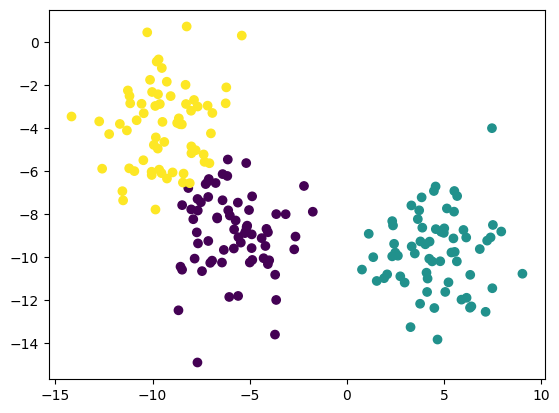

In [76]:
plt.scatter(X[:, 0], X[:, 1], c=sklearn_prediction)
plt.show()

The hard boundary between the two overlapping classes, colored yellow and purple in the example, shows where the misclassifications are occurring.

We will display a text-based confusion matrix that will show how many points were correctly classified (along the diagonal), and how many were misclassified (all off-diagonal non-zero numbers).

But, we need to notice how the labels have permuted:  K-means just creates arbitrary labels, so the purple and yellow groups have swapped places due to different labeling produced by K-means. We must map the labels to our original labeling before testing "accuracy".

In this case, we will *manually* remap using a Python dictionary `sklearn_prediction_remap` to map source labels to  destination labels, then apply it in a list comprehension.

In [77]:
sklearn_prediction_remap = {2:0, 0:2, 1:1}
sklearn_prediction = [sklearn_prediction_remap[l] for l in sklearn_prediction]

Showing the plot to verify that we re-mapped the class labels correctly (the purple should be the upper-left group, the yellow should be the lower-middle group).

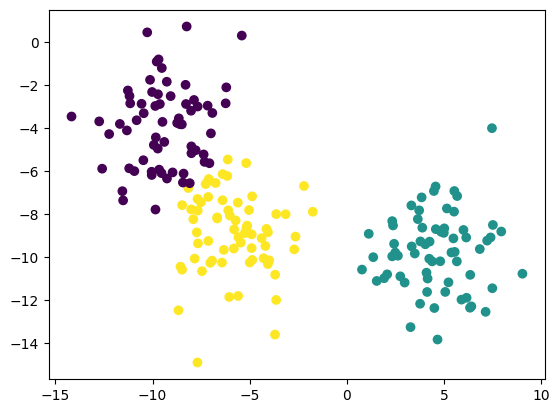

In [78]:
plt.scatter(X[:, 0], X[:, 1], c=sklearn_prediction)
plt.show()

In [79]:
print("\nConfusion matrix from sklearn-kmeans: ")
cm_from_sklearn = confusion_matrix(y, sklearn_prediction)
print(cm_from_sklearn)
print("\nConfusion matrix from sklearn-kmeans (ratios): ")
print(cm_from_sklearn / np.sum(cm_from_sklearn, axis=1))


Confusion matrix from sklearn-kmeans: 
[[62  0  5]
 [ 0 67  0]
 [ 3  0 63]]

Confusion matrix from sklearn-kmeans (ratios): 
[[0.92537313 0.         0.07575758]
 [0.         1.         0.        ]
 [0.04477612 0.         0.95454545]]


#### Insights from Confusion Matrix:
The confusion matrix provides valuable insights into the performance of the clustering algorithm. Each row of the matrix corresponds to a true class, while each column corresponds to a predicted class.

Here's what this confusion matrix tells us:

In the first row, 62 data points from class 0 were correctly classified as class 0, while 5 were misclassified as class 2.
In the second row, all 67 data points from class 1 were correctly classified.
In the third row, 63 data points from class 2 were correctly classified as class 2, while 3 were misclassified as class 0.
The second part of the output, the confusion matrix normalized by the true class sums, provides the ratio of correct classifications within each class. This allows us to see the accuracy of the clustering algorithm for each class.

Overall, it seems like the clustering algorithm performed quite well, especially in distinguishing class 1. However, there were some misclassifications between classes 0 and 2, as evidenced by the off-diagonal elements in the confusion matrix

Now we are displaying the accuracy by group:

In [80]:
print("Accuracy by label:")
acc_by_group_from_sklearn = np.diagonal(cm_from_sklearn) / np.sum(cm_from_sklearn, axis=1)
for i, a in enumerate(acc_by_group_from_sklearn):
    print("Group {} acc: {:.3f}".format(i,a))

Accuracy by label:
Group 0 acc: 0.925
Group 1 acc: 1.000
Group 2 acc: 0.955


this result shows accuracy for each class based on the confusion matrix obtained using the k-means clustering.

- The accuracy for class 0 is approximately 92.5%.
- The accuracy for class 1 is 100%, indicating that all data points belonging to this class were correctly classified.
- The accuracy for class 2 is approximately 95.5%.

Overall, the clustering algorithm achieved high accuracies for all classes, with some slight misclassifications between classes 0 and 2.

## K-Means from Scratch
Let's try to implement a simplified version of k-means from scratch.

The algorithm for K-means is:
    
    * Initialize k means (mi), by choosing randomly from X
    * Repeat the following until the class assignments become stable:
        * Assignment Step:
            * assign each observation (xt) to the nearest mean.
        * Update step:
            * calculate new means to be the centroids of the observations in each cluster.

For our definition of *stable*, we will simply repeat until the class labels do not change in a subsequent iteration of the algorithm, or until a maximum number of iterations (say, 10,000).

For our distance measure, we will just use Euclidean distance.  One way to 
calculate it easily is to use Numpy's linear algebra `norm`:

In [81]:
def distance(a,b):
    """ Calculates and returns Euclidean distance from a to b. """
    return np.linalg.norm(a-b)

Implementing the k-means algorithm shown above.  You may assume that 
X is 2-dimensional. 

In [82]:
def my_kmeans(X, k, random_state=0):
    np.random.seed(random_state)
    # `pred_classes` will contain the numeric label (0,1,2,...,k-1) for each
    # cluster.  We will preallocate it for convenience.
    pred_classes = np.zeros(len(X), dtype=int)
    
    # Step 1: Define initial means
    initial_indices = np.random.choice(len(X), size=k, replace=False)
    means = X[initial_indices]
    
    # Loop until the clustering is stable or a maximum number of iterations is reached
    max_iterations = 10000
    for _ in range(max_iterations):
        # Assignment Step:
        # for each xt (i.e. for each row in X)...
        for i, xt in enumerate(X):
            # Calculate the distance between xt and each of the current means.
            distances = [distance(xt, mean) for mean in means]
            
            # Choose the index of the nearest mean to be the class label for this point.
            #     Hint: The numpy `argmin()` function can make this very easy.
            new_label = np.argmin(distances)
            
            # Determine if the new class label is different from the previous label for
            # this point (this helps us determine whether the clustering is stable or not).
            if pred_classes[i] != new_label:
                pred_classes[i] = new_label
        
        # Update Step:
        # for each of the k means...
        for i in range(k):
            # Update the mean (mi) to be the mean of all samples (rows) in X that are
            # currently labeled with label i.
            # Hint:  Numpy arrays can be indexed with boolean masks.  For example, you
            # can find all rows of X labeled with class i by doing X[pred_classes == i].
            # Also, numpy can take a mean along a selected axis on a numpy array.
            # (See numpy documentation for examples.)
            means[i] = np.mean(X[pred_classes == i], axis=0)
        
    # Return the classes you have computed:
    return np.array(pred_classes)


## Test your algorithm
The following code will perform a clustering with your implementation of
k-means, on the same dataset that we examined above.  Ideally, our result
will look very similar to the one produced by Scikit-Learn.

Predict the classes for all X:

In [91]:
pred_classes = my_kmeans(X, 3)

Creating a scatter plot to see which groups are given which
label.  Keep in mind that the labeling can vary -- the groups should look
similar, but the label (and thus, color) assigned may be different depending
on the random seed used for the initial means.

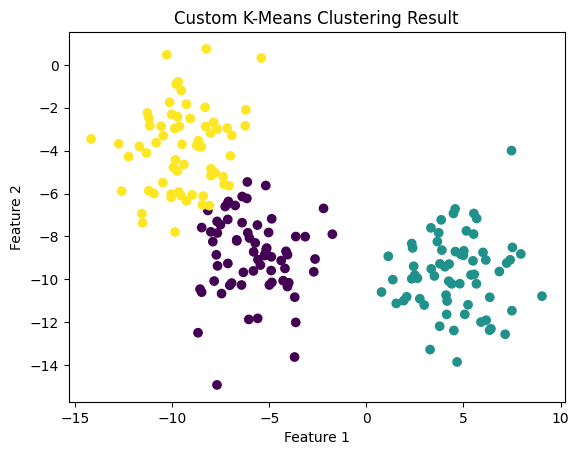

In [92]:
plt.scatter(X[:, 0], X[:, 1], c=pred_classes)
plt.title("Custom K-Means Clustering Result")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


Now, as colors don't match what we want (from the original labels)
shown in the first plot), create a mapping from the labels shown to the
same labelings.

In [93]:
my_kmeans_remap = {2:0, 0:2, 1:1}
pred_classes = [my_kmeans_remap[l] for l in pred_classes]

Now re-plot the points with the remapped labels.  This plot should be a very
close match to the Scikit-Learn result.   There will be misclassification
errors due to the hard separation of the discriminant boundaries.

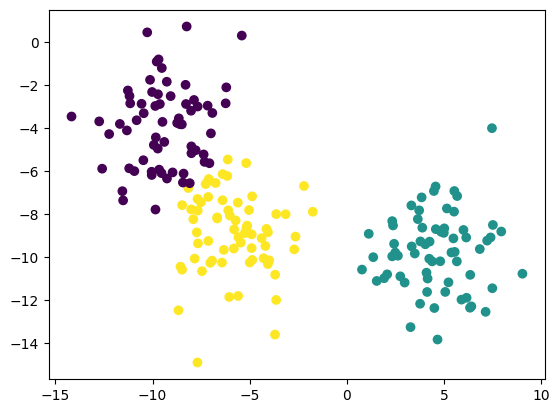

In [94]:
plt.scatter(X[:, 0], X[:, 1], c=pred_classes)
plt.show()

Now let's do the confusion matrix analysis to see the class-wise performance
of our model.  

In [87]:
print("\nConfusion matrix from my_kmeans: ")
cm_my_kmeans = confusion_matrix(y, pred_classes)
print(cm_my_kmeans)
print("\nConfusion matrix from sklearn-kmeans (ratios): ")
print(cm_my_kmeans / np.sum(cm_my_kmeans, axis=1))


Confusion matrix from my_kmeans: 
[[62  0  5]
 [ 0 67  0]
 [ 3  0 63]]

Confusion matrix from sklearn-kmeans (ratios): 
[[0.92537313 0.         0.07575758]
 [0.         1.         0.        ]
 [0.04477612 0.         0.95454545]]


This matrix provides insights into how well the algorithm has performed in terms of classifying the data points into their respective clusters.

Here's what the output tells us:

In the confusion matrix from your custom k-means algorithm:

- Class 0: 62 data points were correctly classified, 5 were misclassified as class 2.
- Class 1: All 67 data points were correctly classified.
- Class 2: 63 data points were correctly classified, 3 were misclassified as class 0.

The confusion matrix normalized by the true class sums provides the ratio of correct classifications within each class, similar to the one obtained from Scikit-Learn's k-means.
Overall, your custom k-means algorithm seems to have performed quite well, with high accuracies for each class. There are some misclassifications, particularly between classes 0 and 2, but the performance is comparable to that of Scikit-Learn's k-means algorithm.

Finally, let's break out the accuracy by class label:

In [95]:
print("Accuracy by label:")
acc_by_group_my_kmeans = np.diagonal(cm_my_kmeans) / np.sum(cm_my_kmeans, axis=1)
for i, a in enumerate(acc_by_group_my_kmeans):
    print("Group {} acc: {:.3f}".format(i,a))

Accuracy by label:
Group 0 acc: 0.925
Group 1 acc: 1.000
Group 2 acc: 0.955


Accuracies for custom k-means clustering algorithm matches perfectly to the ones produced by the Scikit-Learn version. 

*******************************************************************************************************